# Faster RCNN Finetuning
We will finetune a faster RCNN model on a custom dataset (UNO Cards dataset).

Dataset link: https://univpr-my.sharepoint.com/:u:/g/personal/tomaso_fontanini_unipr_it/EStKK8TdTlpNuxofBFHIOksBnifyRmq6EsFUXrCkNtt_zg?e=vICEKq

The dataset consists of 15 classes in total.

- Numbers 0 to 9 on the card have the same labels, that is, 0 to 9. That’s 10 labels there.
- Label 10 corresponds to +4 on card.
- Label 11 is +2 on the card.
- The double arrow on the card has a mapping to label 12.
- The phi ($\phi$) corresponds to label 13.
- And finally, the colored circle (or wildcard symbol) is label 14

![alt text](https://debuggercafe.com/wp-content/uploads/2021/11/different-classes-from-uno-cards-dataset.jpg)

In [1]:
import torch
BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 416 # resize the image for training and transforms
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 0
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory
TRAIN_DIR = 'res/fasterRCNN/Uno Cards.v3-aug416.voc/train'
# validation images and XML files directory
VALID_DIR = 'res/fasterRCNN/Uno Cards.v3-aug416.voc/valid'
# classes: 0 index is reserved for background
CLASSES = [
    '__background__', '11', '9', '13', '10', '6', '7', '0', '5', '4', '2', '14', 
    '8', '12', '1', '3'
]
NUM_CLASSES = len(CLASSES)
# location to save model and plots
OUT_DIR = './res'

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# we will need custom transforms since each transforms need to be applied on the bounding box too
import res.transforms as T
    
# define the training tranforms
def get_train_transform():
    return T.Compose([
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float)#,
        #T.RandomHorizontalFlip(p=0.5), # in this example this is not needed: why?
    ])
# define the validation transforms
def get_valid_transform():
    return T.Compose([
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float)
    ])

In [3]:
# Define the DATASET
import cv2
import numpy as np
import os
import glob as glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# to load bbox files
from xml.etree import ElementTree as et


# Define a function to load images
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
        
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = pil_loader(image_path)
        
        # resize image
        image_resized = image.resize((self.height, self.width))
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width, image_height = image.size
        
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            image_resized, target = self.transforms(image_resized, target)
            
        return image_resized, target
    def __len__(self):
        return len(self.all_images)

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))    
    
# TRAIN DATASET
train_dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
)
print(f"Number of training images: {len(train_dataset)}")

train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )

# TEST DATASET
test_dataset = CustomDataset(
    VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
)
print(f"Number of test images: {len(test_dataset)}")

test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )

Number of training images: 31473
Number of test images: 1798


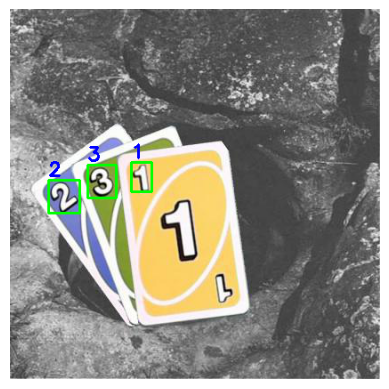

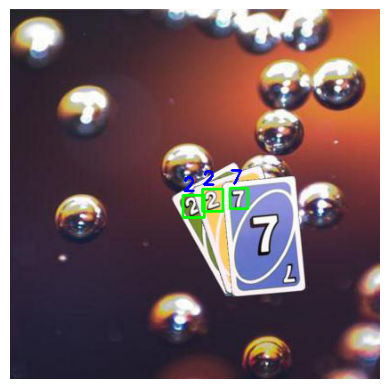

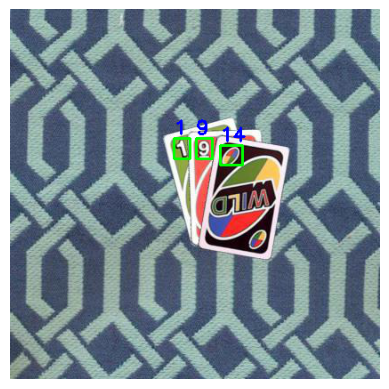

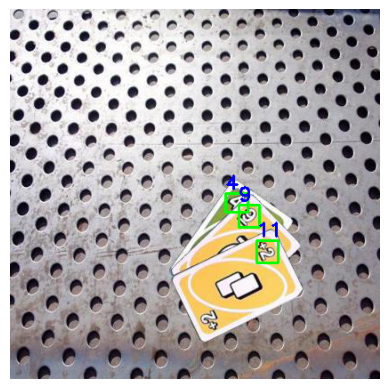

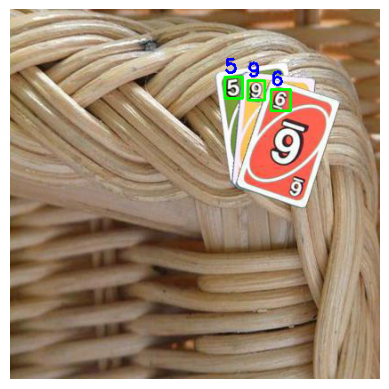

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

to_pil = transforms.ToPILImage()

# function to visualize a single sample
def visualize_sample(image, target):
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        
        image = np.array(to_pil(image))
        
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
    plt.imshow(image)
    plt.axis('off')


NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    plt.figure()
    image, target = test_dataset[i]
    visualize_sample(image, target)

In [9]:
# Create the Faster RCNN model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, trainable_backbone_layers=3)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [10]:
# let's check what paramenters will be learned
for n,p in model.named_parameters():
    if p.requires_grad:
        print(n)

backbone.body.7.block.0.0.weight
backbone.body.7.block.1.0.weight
backbone.body.7.block.2.0.weight
backbone.body.8.block.0.0.weight
backbone.body.8.block.1.0.weight
backbone.body.8.block.2.0.weight
backbone.body.9.block.0.0.weight
backbone.body.9.block.1.0.weight
backbone.body.9.block.2.0.weight
backbone.body.10.block.0.0.weight
backbone.body.10.block.1.0.weight
backbone.body.10.block.2.0.weight
backbone.body.11.block.0.0.weight
backbone.body.11.block.1.0.weight
backbone.body.11.block.2.fc1.weight
backbone.body.11.block.2.fc1.bias
backbone.body.11.block.2.fc2.weight
backbone.body.11.block.2.fc2.bias
backbone.body.11.block.3.0.weight
backbone.body.12.block.0.0.weight
backbone.body.12.block.1.0.weight
backbone.body.12.block.2.fc1.weight
backbone.body.12.block.2.fc1.bias
backbone.body.12.block.2.fc2.weight
backbone.body.12.block.2.fc2.bias
backbone.body.12.block.3.0.weight
backbone.body.13.block.0.0.weight
backbone.body.13.block.1.0.weight
backbone.body.13.block.2.fc1.weight
backbone.body

In [11]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    train_loss_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images =  list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets) # when given images and targets as input it will return the loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

def validate(valid_data_loader, model):
    print('Validating')
    val_itr = 0
    val_loss_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [12]:
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'res/faster_rcnn.pth')

In [13]:
# TRAIN!!!
import time
model.train()
for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(test_loader, model)
        print(f"Epoch #{epoch+1} train loss: {sum(train_loss)//len(train_loader):.3f}")   
        print(f"Epoch #{epoch+1} validation loss: {sum(val_loss)//len(test_loader):.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        # save the current epoch model
        #save_model(epoch, model, optimizer)
        


EPOCH 1 of 10
Training


Loss: 0.6004:   0%|▎                                                               | 35/7869 [00:39<2:27:14,  1.13s/it]


KeyboardInterrupt: 

In [14]:
# load the model and trained weights
checkpoint = torch.load('res/faster_rcnn.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

TEST PREDICTIONS COMPLETE
Average FPS: 6.513


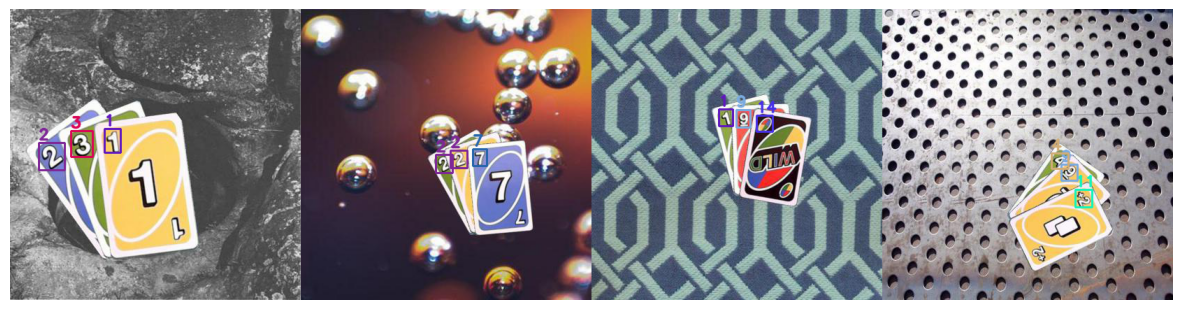

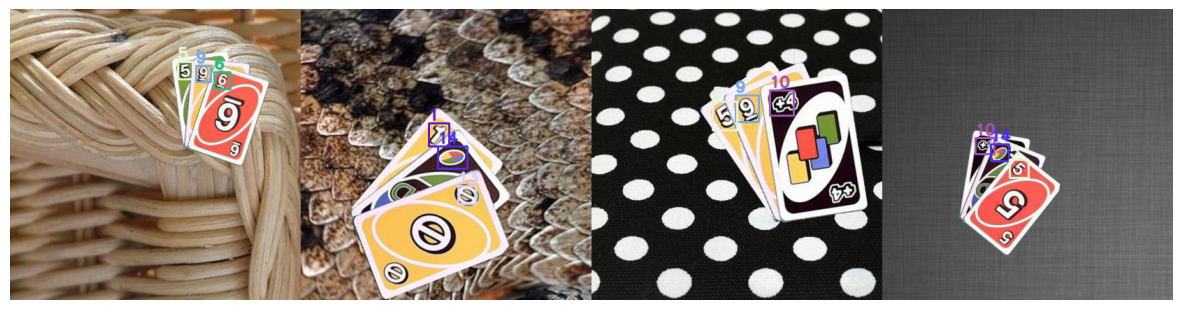

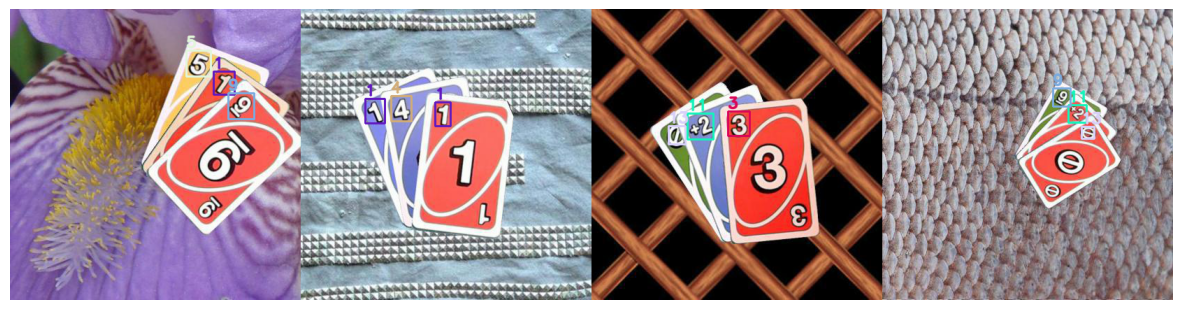

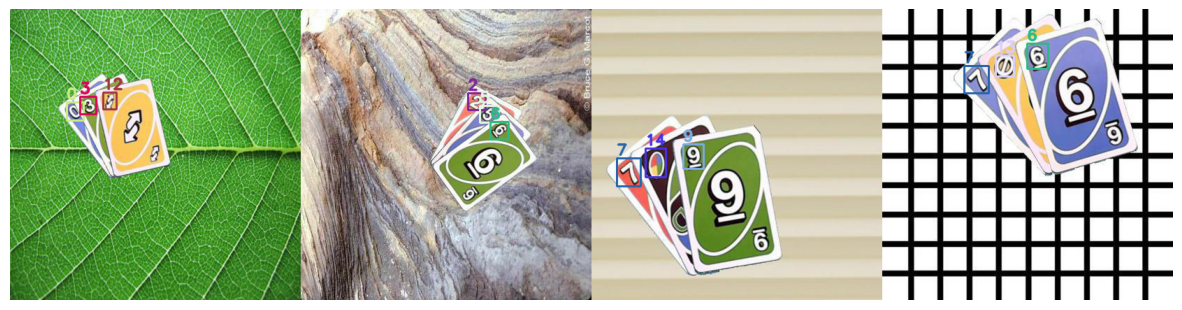

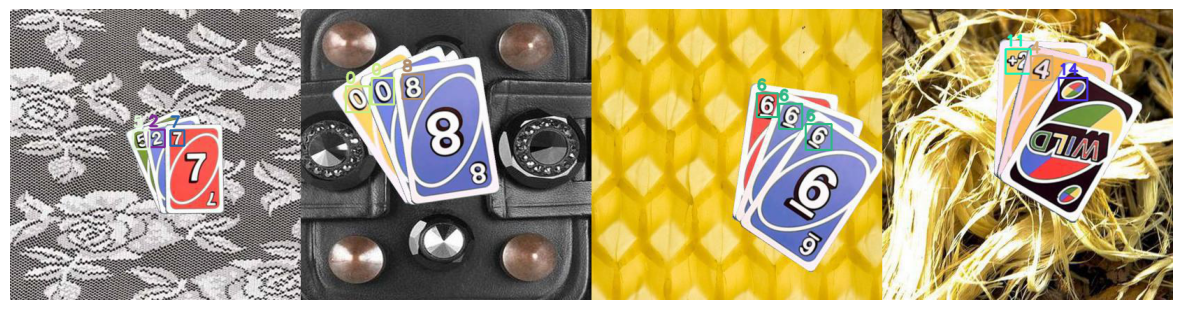

In [18]:
# Evaluate the model and print the results
import time
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0 

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

with torch.no_grad():
    for i, data in enumerate(test_loader):
        
        if i > 4:
            break
            
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        start_time = time.time()
        
        # generate outputs from model
        outputs = model(images) # when given only images as input it will return the generated output
        
        end_time = time.time()
        # get the current fps
        fps = 1 / (end_time - start_time)
        # add `fps` to `total_fps`
        total_fps += fps
        # increment frame count
        frame_count += 1
        # load all detection to CPU for further operations
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        
        images = [np.array(to_pil(im)) for im in images]
        
        targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
        
        plt.figure(figsize=(15,15))
        res_list = []
        for (out, im, trg) in zip(outputs, images, targets):
            # carry further only if there are detected boxes
            if len(out['boxes']) != 0:
                boxes = out['boxes'].data.numpy()
                scores = out['scores'].data.numpy()
                # filter out boxes according to `detection_threshold`
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                # get all the predicited class names
                pred_classes = [CLASSES[i] for i in out['labels'].cpu().numpy()]

                # draw the bounding boxes and write the class name on top of it
                for j, box in enumerate(draw_boxes):
                    class_name = pred_classes[j]
                    color = COLORS[CLASSES.index(class_name)]
                    cv2.rectangle(im,
                                (int(box[0]), int(box[1])),
                                (int(box[2]), int(box[3])),
                                color, 2)
                    cv2.putText(im, class_name, 
                                (int(box[0]), int(box[1]-5)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                                2, lineType=cv2.LINE_AA)
                 
                res_list.append(im)
        
        res_list = np.concatenate(res_list, axis=1)
        plt.axis("off")
        plt.imshow(res_list)

print('TEST PREDICTIONS COMPLETE')
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Model Link: https://univpr-my.sharepoint.com/:u:/g/personal/tomaso_fontanini_unipr_it/ERhuMQLHKL9IqkZSP-SYZLkBf_jSm1Xe0jqWGKg8Tud-Ig?e=G6OpBi